# playing Atari with Deep Learning

In [3]:
# choose game
game = "Pong-v0"

# generate Dataset by random play

* saving only good sequences

In [4]:
import numpy as np
import gym

env = gym.make(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 5#1500
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 100 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

Dataset completed
Dataset completed


# Preprocessing

In [5]:
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data.shape, y_data.shape

((446, 210, 160, 3), (446,))

In [6]:
x_data[0].shape

(210, 160, 3)

### resize images to 84x84 pixels

In [7]:
import cv2
def resize(img):
    height = 84
    width = 84
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

In [8]:
resized_x_data = [resize(img) for img in x_data]
resized_x_data = np.array(resized_x_data)

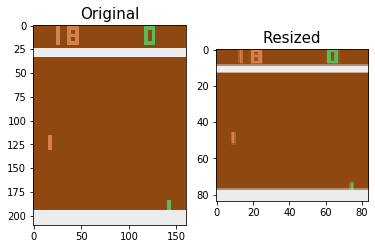

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, axs = plt.subplots(1,2)

axs[0].imshow(x_data[0, :, :, :])
axs[0].set_title("Original", fontsize="15")
axs[1].imshow(resized_x_data[0, :, :, :])
axs[1].set_title("Resized", fontsize="15")
plt.show()

### RGB to Grayscale

In [11]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [12]:
gray_x_data = [grayscale(img) for img in resized_x_data]
gray_x_data = np.array(gray_x_data)

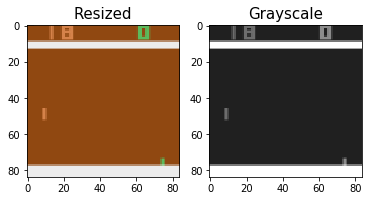

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(resized_x_data[0, :, :, :])
axs[0].set_title("Resized", fontsize="15")
axs[1].imshow(gray_x_data[0, :, :, 0], cmap="gray")
axs[1].set_title("Grayscale", fontsize="15")
plt.show()

### Frame Stack

In [58]:
from collections import deque
def framestack(dataset):
    data = []
    frames = deque(maxlen=4)

    # initialize first deque
    for _ in range(4):
        frames.append(dataset[0])
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)

    # create deques from dataset
    for state in dataset:
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)
        data.append(framestack)

    return data

In [108]:
stack_data = framestack(gray_x_data) 
stack_data = np.array(stack_data)

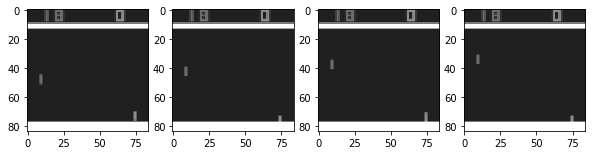

In [109]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
axs[0].imshow(stack_data[0+4, :, :, 0], cmap="gray") # +4, because of 4 same initial frames
axs[1].imshow(stack_data[1+4, :, :, 1], cmap="gray")
axs[2].imshow(stack_data[2+4, :, :, 2], cmap="gray")
axs[3].imshow(stack_data[3+4, :, :, 3], cmap="gray")
plt.show()

### Sequenes

In [14]:
x_data.shape, y_data.shape

((446, 210, 160, 3), (446,))

In [19]:
np.shape(x_data[4]), y_data[:4]

((210, 160, 3), array([0, 5, 3, 4]))

In [126]:
def sequences(x_data, y_data):
    x = [x_data[:4]]
    y = [y_data[3]]
    
    n = 4
    for i in range(n, x_data.shape[0]):
        x.append(x_data[4:n+4])
        y.append(y_data[i])
   
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [129]:
x_sequences, y_sequences = sequences(gray_x_data, y_data)

### converting labels to categorical labels

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y=y_data, num_classes=env.action_space.n)

### shuffle data

In [15]:
# create random indices
idx = np.random.permutation(len(x_data))
# x - resized grayscale input
# x_stacked - resized grayscale input in framestacks
# labels - actions in to_categorical
x, x_stacked, labels = gray_x_data[idx], stack_data[idx], y[idx]

# create a model


In [103]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def create_nn(input_shape, output_shape, lstm):
    net_input = Input(shape=input_shape) 
    
    if lstm: # Input: samples, time, rows, cols, channels
        x = ConvLSTM(filters=32, kenrel_size=(8, 8), strides=(4, 4), padding="same", return_sequences=True, data_format='channels_first')(net_input)
        x = ConvLSTM(filters=64, kenrel_size=(4, 4), strides=(2, 2), padding="same", return_sequences=True)(x)
        x = ConvLSTM(filters=64, kenrel_size=(3, 3), strides=(1, 1), padding="same", return_sequences=False)(x)
    else: # Input: rows, cols, channels
        x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu")(net_input)
        x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu")(x)
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    net_output = Dense(output_shape, activation="softmax")(x)

    OPTIMIZER = Adam(lr=0.00005)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["categorical_accuracy"])

    return model

# Train a model on resized-grayscale input



In [17]:
x.shape[1:]

(84, 84, 1)

In [18]:
labels.shape[1]

6

In [19]:
model_1 = create_nn(x.shape[1:], labels.shape[1], false)

In [20]:
EPOCHS = 85

result_1 = model_1.fit(
    x,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/85


W0202 15:30:39.399999 140341478131520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


115684/115684 [==============================] - 19s 163us/sample - loss: 1.9326 - categorical_accuracy: 0.1675
Epoch 2/85
115684/115684 [==============================] - 8s 69us/sample - loss: 1.8110 - categorical_accuracy: 0.1727
Epoch 3/85
115684/115684 [==============================] - 8s 69us/sample - loss: 1.8001 - categorical_accuracy: 0.1752
Epoch 4/85
115684/115684 [==============================] - 8s 69us/sample - loss: 1.7953 - categorical_accuracy: 0.1774
Epoch 5/85
115684/115684 [==============================] - 8s 68us/sample - loss: 1.7919 - categorical_accuracy: 0.1790
Epoch 6/85
115684/115684 [==============================] - 8s 66us/sample - loss: 1.7896 - categorical_accuracy: 0.1836
Epoch 7/85
115684/115684 [==============================] - 8s 66us/sample - loss: 1.7879 - categorical_accuracy: 0.1857
Epoch 8/85
115684/115684 [==============================] - 8s 68us/sample - loss: 1.7871 - categorical_accuracy: 0.1874
Epoch 9/85
115684/115684 [===============

In [21]:
model_1.save_weights("model_1_1500Examples_85Epochs.h5")

In [22]:
for episode in range(5):
    done = False
    episode_reward = 0.0
    state = env.reset()
    state = resize(state)
    state = grayscale(state)
    state = np.reshape(state, (1, 84, 84, 1))
    state = state.astype("float32")
    while not done:
        action = np.argmax(model_1.predict(state))
        state, reward, done, info = env.step(action)
        state = resize(state)
        state = grayscale(state)
        state = np.reshape(state, (1, 84, 84, 1))
        state = state.astype("float32")
        episode_reward += reward
    print("Episode:", episode+1, "\tReward:", episode_reward)

Episode: 1 	Reward: -15.0
Episode: 2 	Reward: -17.0
Episode: 3 	Reward: -12.0
Episode: 4 	Reward: -15.0
Episode: 5 	Reward: -18.0


In [33]:
res1_loss = result_1.history['loss']
res1_acc = result_1.history['categorical_accuracy']

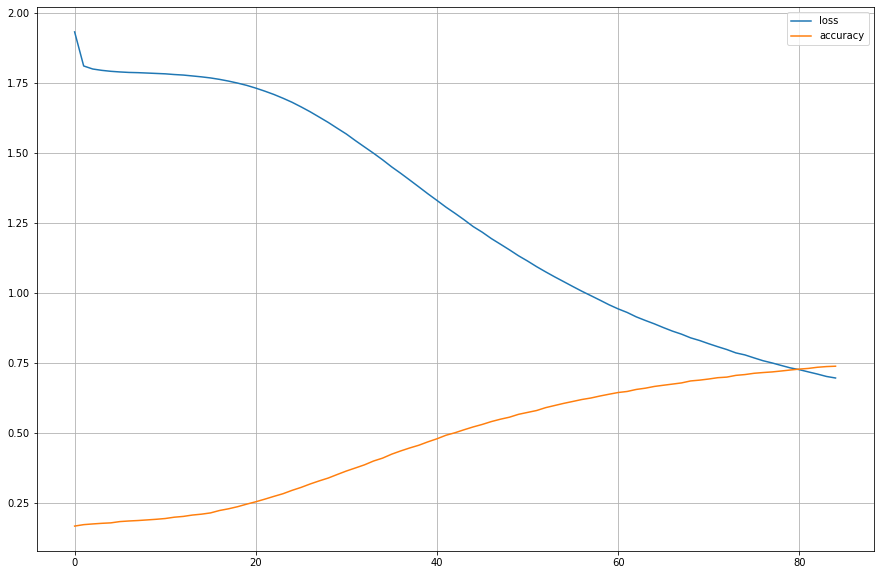

In [39]:
plt.figure(figsize=(15,10))
plt.grid(linestyle='-')
plt.plot(res1_loss, label="loss")
plt.plot(res1_acc, label="accuracy")
plt.legend()
plt.show()

In [40]:
import pandas as pd
df = pd.DataFrame(list(zip(res1_loss, res1_acc)), 
               columns =['Loss', 'Accuracy']) 
df.to_csv("model_1_1500Examples_85Epochs.csv",mode="w", index=False)

# Train a model on resized-grayscale-framestack input



In [23]:
x_stacked.shape[1:]

(84, 84, 4)

In [24]:
labels.shape[1]

6

In [25]:
model_2 = create_nn(x_stacked.shape[1:], labels.shape[1], false)

In [26]:
EPOCHS = 85#250

result_2 = model_2.fit(
    x_stacked,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/85
115684/115684 [==============================] - 40s 350us/sample - loss: 2.0848 - categorical_accuracy: 0.1699
Epoch 2/85
115684/115684 [==============================] - 37s 324us/sample - loss: 1.8167 - categorical_accuracy: 0.1733
Epoch 3/85
115684/115684 [==============================] - 43s 375us/sample - loss: 1.8028 - categorical_accuracy: 0.1754
Epoch 4/85
115684/115684 [==============================] - 37s 324us/sample - loss: 1.7953 - categorical_accuracy: 0.1812
Epoch 5/85
115684/115684 [==============================] - 36s 307us/sample - loss: 1.7924 - categorical_accuracy: 0.1808
Epoch 6/85
115684/115684 [==============================] - 36s 314us/sample - loss: 1.7891 - categorical_accuracy: 0.1856
Epoch 7/85
115684/115684 [==============================] - 37s 320us/sample - loss: 1.7860 - categorical_accuracy: 0.1891
Epoch 8/85
115684/115684 [==============================] - 38s 325us/sample - loss: 1.7834 - categorical_accuracy: 0.1941
Epoch 9/85
11568

In [27]:
model_2.save_weights("model_2_1500Examples_85Epochs.h5")

In [28]:
for episode in range(5):
    done = False
    episode_reward = 0.0
    state = env.reset()
    state = resize(state)
    state = grayscale(state)
    state = np.reshape(state, (84, 84, 1))
    frames = deque(maxlen=4)
    # initialize deque for framestack
    for _ in range(4):
        frames.append(state)
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(1, 84, 84, 4)#reshape(84, 84, -1)

    # playing a episode
    while not done:
        action = np.argmax(model_2.predict(framestack))
        state, reward, done, info = env.step(action)
        episode_reward += reward
        state = resize(state)
        state = grayscale(state)
        state = np.reshape(state, (84, 84, 1))
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(1, 84, 84, 4)
        
    print("Episode:", episode+1, "\tReward:", episode_reward)

Episode: 1 	Reward: -17.0
Episode: 2 	Reward: -14.0
Episode: 3 	Reward: -16.0
Episode: 4 	Reward: -18.0
Episode: 5 	Reward: -17.0


In [41]:
res2_loss = result_2.history['loss']
res2_acc = result_2.history['categorical_accuracy']

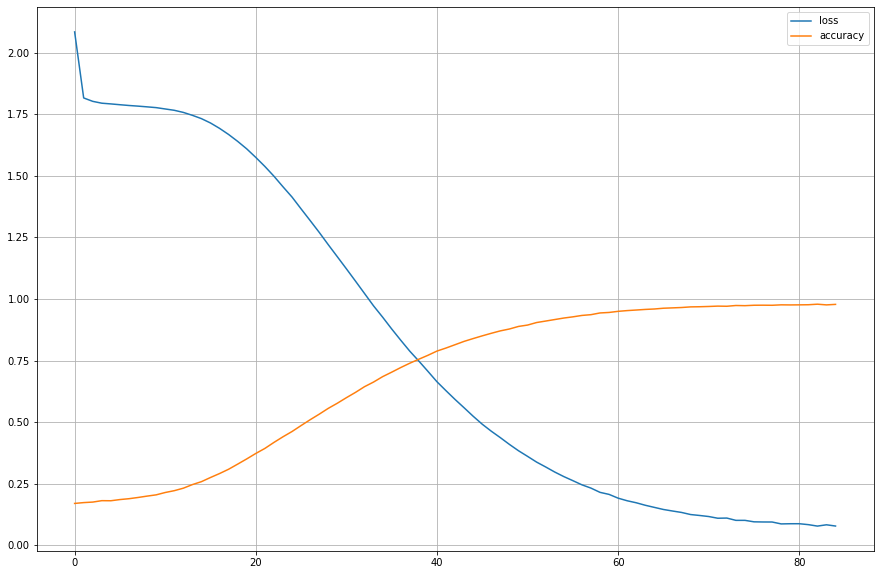

In [43]:
plt.figure(figsize=(15,10))
plt.grid(linestyle='-')
plt.plot(res2_loss, label="loss")
plt.plot(res2_acc, label="accuracy")
plt.legend()
plt.show()

In [44]:
df = pd.DataFrame(list(zip(res2_loss, res2_acc)), 
               columns =['Loss', 'Accuracy']) 
df.to_csv("model_2_1500Examples_85Epochs.csv",mode="w", index=False)